# Training Resnet20 on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

## Step 0: Set up the Resnet20 model
As you have practiced to implement simple neural networks in Homework 1, we just prepare the implementation for you.

In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def swish(x):
    return x/(1+torch.exp(-x))

In [3]:
# define the Resnet20 mode;
class Resnet20(nn.Module):
    def __init__(self):
        super(Resnet20, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm0 = nn.BatchNorm2d(16)
        
        self.conv1a = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1a = nn.BatchNorm2d(16)
        self.conv1b = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1b = nn.BatchNorm2d(16)
        self.conv1c = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1c = nn.BatchNorm2d(16)
        self.conv1d = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1d = nn.BatchNorm2d(16)
        self.conv1e = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1e = nn.BatchNorm2d(16)
        self.conv1f = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1f = nn.BatchNorm2d(16)
        
        self.conv1_2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.batchnorm1_2 = nn.BatchNorm2d(32)
        self.bypass1_2 = nn.Conv2d(16, 32, 1, stride=2)
        self.conv2a = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2a = nn.BatchNorm2d(32)
        self.conv2b = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2b = nn.BatchNorm2d(32)
        self.conv2c = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2c = nn.BatchNorm2d(32)
        self.conv2d = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2d = nn.BatchNorm2d(32)
        self.conv2e = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2e = nn.BatchNorm2d(32)
        
        self.conv2_3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.batchnorm2_3 = nn.BatchNorm2d(64)
        self.bypass2_3 = nn.Conv2d(32, 64, 1, stride=2)
        self.conv3a = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3a = nn.BatchNorm2d(64)
        self.conv3b = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3b = nn.BatchNorm2d(64)
        self.conv3c = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3c = nn.BatchNorm2d(64)
        self.conv3d = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3d = nn.BatchNorm2d(64)
        self.conv3e = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3e = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        # Inital convolution
        out = self.batchnorm0(self.conv0(x))
        out = bypass = swish(out)
        # Block 1   (condense block layers into functions)
            # Layer 1
        out = self.batchnorm1a(self.conv1a(out))
        out = swish(out)
        out = self.batchnorm1b(self.conv1b(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm1c(self.conv1c(out))
        out = swish(out)
        out = self.batchnorm1d(self.conv1d(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm1e(self.conv1e(out))
        out = swish(out)
        out = self.batchnorm1f(self.conv1f(out))
        out = bypass = swish(out + bypass)
        # Block 2
            # Layer 1
        bypass = self.bypass1_2(bypass)
        out = self.batchnorm1_2(self.conv1_2(out))
        out = swish(out)
        out = self.batchnorm2a(self.conv2a(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm2b(self.conv2b(out))
        out = swish(out)
        out = self.batchnorm2c(self.conv2c(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm2d(self.conv2d(out))
        out = swish(out)
        out = self.batchnorm2e(self.conv2e(out))
        out = bypass = swish(out + bypass)
        # Block 3
            # Layer 1
        bypass = self.bypass2_3(bypass)
        out = self.batchnorm2_3(self.conv2_3(out))
        out = swish(out)
        out = self.batchnorm3a(self.conv3a(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm3b(self.conv3b(out))
        out = swish(out)
        out = self.batchnorm3c(self.conv3c(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm3d(self.conv3d(out))
        out = swish(out)
        out = self.batchnorm3e(self.conv3e(out))
        out = bypass = swish(out + bypass)
        
        # Global Average Pool to go from 8x8 -> 1x1 feature maps
        out = F.avg_pool2d(out, 8)
        
        # Fully Connected Layer
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

### Question (a)
Here is a sanity check to verify the implementation of SimpleNN. 
You need to:
1. Write down your code.
2. **In the PDF report**, give a brief description on how the code helps you know that SimpleNN is implemented correctly.

In [4]:
#############################################
# your code here
# sanity check for the correctness of SimpleNN
dummy_input = torch.ones((1,3,32,32))
dummy_instance = Resnet20()
print(dummy_instance.forward(dummy_input))
total_params = 1
for p in dummy_instance.parameters():
    temp = 1
    for s in p.size():
        temp *= s
    total_params += temp
    #print(p.size())
print(f"Total Number of Parameters: {total_params}")

#############################################

tensor([[-0.0812,  0.1049,  0.4072, -0.4362,  0.0967,  0.3175, -0.1313, -0.3274,
          0.0867,  0.0045]], grad_fn=<AddmmBackward0>)
Total Number of Parameters: 273067


## Step 1: Set up preprocessing functions
Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

### Question (b)
For the question, you need to:
1. Complete the preprocessing code below.
2. **In the PDF report**, briefly describe what preprocessing operations you used and what are the purposes of them.

Hint: 
1. Only two operations are necessary to complete the basic preprocessing here.
2. The raw input read from the dataset will be PIL images.
3. Data augmentation operations are not mendatory, but feel free to incorporate them if you want.
4. Reference value for mean/std of CIFAR-10 images (assuming the pixel values are within [0,1]): mean (RGB-format): (0.4914, 0.4822, 0.4465), std (RGB-format): (0.2023, 0.1994, 0.2010)

In [52]:
# useful libraries
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10 as torchCIFAR10

#############################################
# your code here
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# specify preprocessing function
transform_train = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std),
                                     transforms.RandomCrop(size=32, padding=4),
                                     transforms.RandomHorizontalFlip()])

transform_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

transform_visulaizer = transforms.Compose([transforms.ToTensor()])
#############################################

## Step 2: Set up dataset and dataloader

### Question (c)
Set up the train/val datasets and dataloders that are to be used during the training. Check out the [official API](https://pytorch.org/docs/stable/data.html) for more information about **torch.utils.data.DataLoader**.

Here, you need to:
1. Complete the code below.

In [53]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform= transform_train
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform= transform_val
)
test_set = CIFAR10(
    root=DATA_ROOT,
    mode='test',
    download=True,
    transform=transform_test
)
torch_test_set = torchCIFAR10(
    root=DATA_ROOT,
    train=False,
    transform=transform_test,
    download=True
)
torch_vis_set = torchCIFAR10(
    root=DATA_ROOT,
    train=False,
    transform=transform_visulaizer,
    download=True
)


# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size= TRAIN_BATCH_SIZE,  # your code
    shuffle= True,     # your code
    num_workers=4
)
val_loader = DataLoader(
    val_set, 
    batch_size= VAL_BATCH_SIZE,  # your code
    shuffle= False,     # your code
    num_workers=4
)
test_loader = DataLoader(
    test_set
)
torch_test_loader = DataLoader(
    torch_test_set
)
torch_visualizer_loader = DataLoader(
    torch_vis_set
)
#############################################

Using downloaded and verified file: ./data\cifar10_trainval_F22.zip
Extracting ./data\cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data\cifar10_trainval_F22.zip
Extracting ./data\cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data\cifar10_test_F22.zip
Extracting ./data\cifar10_test_F22.zip to ./data
Files already downloaded and verified
test size: 10000
Files already downloaded and verified
Files already downloaded and verified


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.
### Question (d)
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

Here, you need to:
1. Complete the code below.
2. **In the PDF report**, briefly describe how you verify that your model is indeed deployed on GPU. (Hint: check $\texttt{nvidia-smi}$.)

In [75]:
# specify the device for computation
#############################################
# your code here
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cnn = Resnet20()
print(next(cnn.parameters()).device)
cnn.to(device)
print(next(cnn.parameters()).device)

#############################################

cuda:0
cpu
cuda:0


## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum. 

### Question (e)
Here, you need to:
1. Set up the cross-entropy loss as the criterion. (Hint: there are implemented functions in **torch.nn**)
2. Specify a SGD optimizer with momentum. (Hint: there are implemented functions in **torch.optim**)

In [76]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
WARMUP_LR = .01

# momentum for optimizer
MOMENTUM = 0.9

# L2 or L1 regularization strength
REG = 5e-4

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss()

# Add optimizer
#optimizer for L2 regularization
optimizer = optim.SGD(cnn.parameters(), lr=WARMUP_LR, momentum=MOMENTUM, weight_decay=REG)
#optimizer for L1 regularization
#optimizer = optim.SGD(cnn.parameters(), lr=INITIAL_LR, momentum=MOMENTUM)
#############################################

## Step 5: Start the training process.

### Question (f)/(g)
Congratulations! You have completed all of the previous steps and it is time to train our neural network.

Here you need to:
1. Complete the training codes.
2. Actually perform the training.

Hint: Training a neural network usually repeats the following 4 steps: 

**i) Get a batch of data from the dataloader and copy it to your device (GPU).**

**ii) Do a forward pass to get the outputs from the neural network and compute the loss. Be careful about your inputs to the loss function. Are the inputs required to be the logits or softmax probabilities?)**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

**iiii) Update the model weights with the optimizer.**

You will also need to compute the accuracy of training/validation samples to track your model's performance over each epoch (the accuracy should be increasing as you train for more and more epochs).


In [77]:
# some hyperparameters
# total number of training epochs
EPOCHS = 150

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = WARMUP_LR
INITAL_LR = .1
DECAY_EPOCHS = 60
DECAY = .1


print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    if i == 5:
        current_learning_rate = INITAL_LR

    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    #######################
    # your code here
    # switch to train mode
    
    cnn.train()
    
    #######################
    
    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device) 
        targets = targets.type(torch.LongTensor)   #Cast target to long tensor type
        targets = targets.to(device)
        
        # compute the output and loss
        output = cnn.forward(inputs)
        #   loss function for L2 Regularization (reg is handled in the optimizer)
        loss = criterion(output, targets)   #Pass in softmax of final FC layer output for cross-entropy loss
        #   loss function for L1 Regularization
        #L1norm = sum(torch.sum(torch.abs(p)) for p in cnn.parameters())
        #loss = criterion(output, targets) + REG * L1norm
        if i == 0 and batch_idx < 3:
            print(f"Loss after {batch_idx} batches: {loss}")
        train_loss += loss
        
        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation
        loss.backward()
        
        # apply gradient and update the weights
        optimizer.step()
        
        # count the number of correctly predicted samples in the current batch
        total_examples += targets.size()[0]
        batch_preds = torch.argmax(output, dim=1)
        correct_examples += (batch_preds == targets).int().sum().item()
        ####################################
                
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    
    cnn.eval()
    
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            if batch_idx < 45:      # save the last 5 validation batches for testing later
                ####################################
                # your code here
                # copy inputs to device

                inputs = inputs.to(device)
                targets = targets.type(torch.LongTensor)
                targets = targets.to(device)

                # compute the output and loss
                output = cnn.forward(inputs)
                loss = criterion(output, targets)
                val_loss += loss
                
                # count the number of correctly predicted samples in the current batch
                total_examples += targets.size()[0]
                batch_preds = torch.argmax(output, dim=1)
                correct_examples += (batch_preds == targets).int().sum().item()
                ####################################

    avg_loss = val_loss / 45
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    
    # save the model checkpoint
#     if avg_acc > best_val_acc:
#         best_val_acc = avg_acc
#         if not os.path.exists(CHECKPOINT_FOLDER):
#            os.makedirs(CHECKPOINT_FOLDER)
#         print("Saving ...")
#         state = {'state_dict': cnn.state_dict(),
#                 'epoch': i,
#                 'lr': current_learning_rate}
#         torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'resnet20.pth'))
        
#     print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Loss after 0 batches: 2.3285913467407227
Loss after 1 batches: 2.2951748371124268
Loss after 2 batches: 2.2635257244110107
Training loss: 1.6730, Training accuracy: 0.3688
Validation loss: 1.4507, Validation accuracy: 0.4773
Saving ...

Epoch 1:
Training loss: 1.2229, Training accuracy: 0.5564
Validation loss: 1.1721, Validation accuracy: 0.5762
Saving ...

Epoch 2:
Training loss: 0.9871, Training accuracy: 0.6476
Validation loss: 1.0869, Validation accuracy: 0.6180
Saving ...

Epoch 3:
Training loss: 0.8630, Training accuracy: 0.6938
Validation loss: 0.9828, Validation accuracy: 0.6620
Saving ...

Epoch 4:
Training loss: 0.7703, Training accuracy: 0.7288
Validation loss: 0.8369, Validation accuracy: 0.7133
Saving ...

Epoch 5:
Training loss: 0.7141, Training accuracy: 0.7490
Validation loss: 0.7949, Validation accuracy: 0.7282
Saving ...

Epoch 6:
Training loss: 0.6588, Training accuracy: 0.7717
Validation loss: 0.7337, Validation accuracy: 0.7513
Saving 

### Find max softmax statistics for in-distribution testing examples

In [78]:
cnn = Resnet20().to(device)
cnn.load_state_dict(torch.load("saved_model/resnet20.pth")["state_dict"])
cnn.eval()

total_examples = 0
correct_examples = 0
val_loss = 0 
corr_max_softs = []
fals_max_softs = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        if batch_idx >= 45:    #only use the examples reserved for testing
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.type(torch.LongTensor)
            targets = targets.to(device)
            # compute the output and loss
            output = cnn.forward(inputs)
            softmax = F.softmax(output, dim=1)
            loss = criterion(output, targets)
            val_loss += loss
            # count the number of correctly predicted samples in the current batch
            total_examples += targets.size()[0]
            batch_preds = torch.argmax(output, dim=1)
            correct_mask = (batch_preds == targets)
            correct_examples += correct_mask.int().sum().item()

            soft_batch_preds = torch.argmax(softmax, dim=1)
            for i in range(len(correct_mask)):
                if correct_mask[i]:
                    corr_max_softs.append(softmax[i][soft_batch_preds[i]].item())
                else:
                    fals_max_softs.append(softmax[i][soft_batch_preds[i]].item())

print(correct_examples/total_examples)

0.916


#### ROC Curve to show if softmax can be used to show misclassifications of in-distribution samples

In [148]:
import numpy as np
# true positive here is defined as correctly classifying a prediction as erroneous
def plot_roc(false_softs, true_softs, title = "ROC Curve"):
    TPRs = []     #  true positive rates
    FPRs = []     # false positive rates
    opt = {"thresh":-1, "diff":-1, "FPR":-1, "TPR":-1}
    for i in np.linspace(0, 1, 1000):
        TPR = sum(false_softs < i)/len(false_softs)
        FPR = sum(true_softs < i)/len(true_softs)
        TPRs.append(TPR)
        FPRs.append(FPR)
        if TPR-FPR > opt["diff"]:
            opt["thresh"], opt["diff"], opt["FPR"], opt["TPR"]  = i, TPR-FPR, FPR, TPR
    plt.plot(FPRs, TPRs, 'm')
    plt.plot([0,1], [0,1], "k--", linewidth=.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.plot(opt["FPR"], opt["TPR"], 'X', ms=11, label=f"OPT Thresh: {round(opt['thresh'],3)}")
    plt.legend()
    plt.show()
    print(opt)

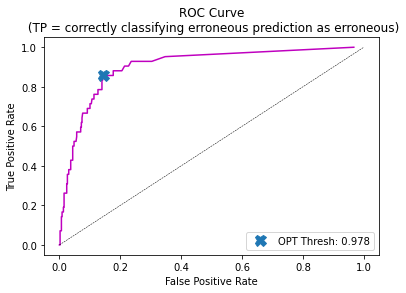

{'thresh': 0.9779779779779779, 'diff': 0.7130380536494073, 'FPR': 0.14410480349344978, 'TPR': 0.8571428571428571}


In [149]:
plot_roc(fals_max_softs, corr_max_softs, title="ROC Curve\n (TP = correctly classifying erroneous prediction as erroneous)")

# OOD Detection on CIFAR-100

In [126]:
from torchvision.datasets import CIFAR100

cifar100_set = CIFAR100(
    root=DATA_ROOT,
    train=False,
    transform=transform_visulaizer,
    download=True
)

cifar100_loader = DataLoader(
    cifar100_set
)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data\cifar-100-python.tar.gz to ./data


In [150]:
OOD_softs = []
with torch.no_grad():
    for i, (img, target) in enumerate(cifar100_loader):
        img = img.to(device)
        target = target.type(torch.LongTensor)
        target = target.to(device)

        output = cnn.forward(img)
        softmax = F.softmax(output, dim=1)
        OOD_softs.append(softmax[0][torch.argmax(softmax)].item())
        batch_pred = torch.argmax(output, dim=1)
        if i%1000 == 0:
            print(f"{i}/{len(cifar100_loader)}")
            
InD_softs = fals_max_softs + corr_max_softs

0/10000
1000/10000
2000/10000
3000/10000
4000/10000
5000/10000
6000/10000
7000/10000
8000/10000
9000/10000


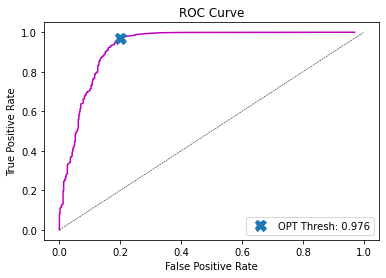

{'thresh': 0.975975975975976, 'diff': 0.7728999999999999, 'FPR': 0.198, 'TPR': 0.9709}


In [151]:
plot_roc(OOD_softs, InD_softs)

In [136]:
#unseen_lbls = list(np.linspace(0,99,100))
# with torch.no_grad():
#     for i, (img, target) in enumerate(cifar100_loader):
#         #if target.item() in unseen_lbls:
#         if target.item() == 81:
#             plt.imshow(torch.permute(torch.squeeze(img), (1,2,0)).cpu().numpy())
#             plt.show()
#             print(target.item())
#             #unseen_lbls.remove(target.item())